In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime

import xesmf as xe
import scipy.signal as signal
import scipy.stats as st
import xgcm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import cartopy.crs as ccrs
import cmocean

from glob import glob
import sys
sys.path.append('../')
from utils import *
from load import *
from numerics import *



In [3]:
gridd1 = xr.open_dataset('data/DESALADORAS_RUND1/original/crocod1_grd.nc').load()

In [4]:
paths   = sorted(glob('data/DESALADORAS_RUND1/original/*avg*.nc'))[12:]
control = xr.open_mfdataset(paths, parallel=True)
control = center_crocogrid(control, control.keys())
control = fix_crocotime(control, YORIG='1949-12-31 00:00:00')

salt_control = control.salt.load()



In [6]:
u,v = control.isel(s_rho=-1).sel(time='2001').u.load(), control.isel(s_rho=-1).sel(time='2001').v.load()

control_eke = (u.groupby('time.month')-u.groupby('time.month').mean('time'))**2+(v.groupby('time.month')-v.groupby('time.month').mean('time'))**2
control_eke = control_eke*0.5
control_eke = control_eke.mean('time')

(-32.5, -28.5)

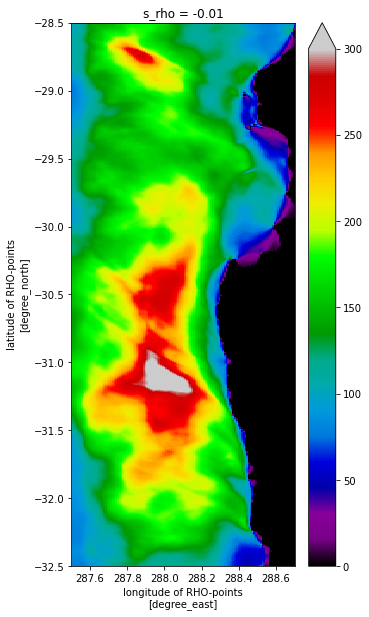

In [10]:
# gridd0.mask_rho.where(gridd0.mask_rho==0).plot()
(1e4*control_eke).plot(x='lon_rho',y='lat_rho', cmap='nipy_spectral', zorder=1, vmin=0, vmax=300, figsize=(5,10))
plt.xlim(287.5,288.7)
plt.ylim(-32.5,-28.5)


In [23]:
paths   = sorted(glob('data/DESALADORAS_RUND1_RIOS/original/*avg*.nc'))
rivers = xr.open_mfdataset(paths, parallel=True)
rivers = center_crocogrid(rivers, rivers.keys())
rivers = fix_crocotime(rivers, YORIG='1949-12-31 00:00:00')

salt_rivers = rivers.salt.load()



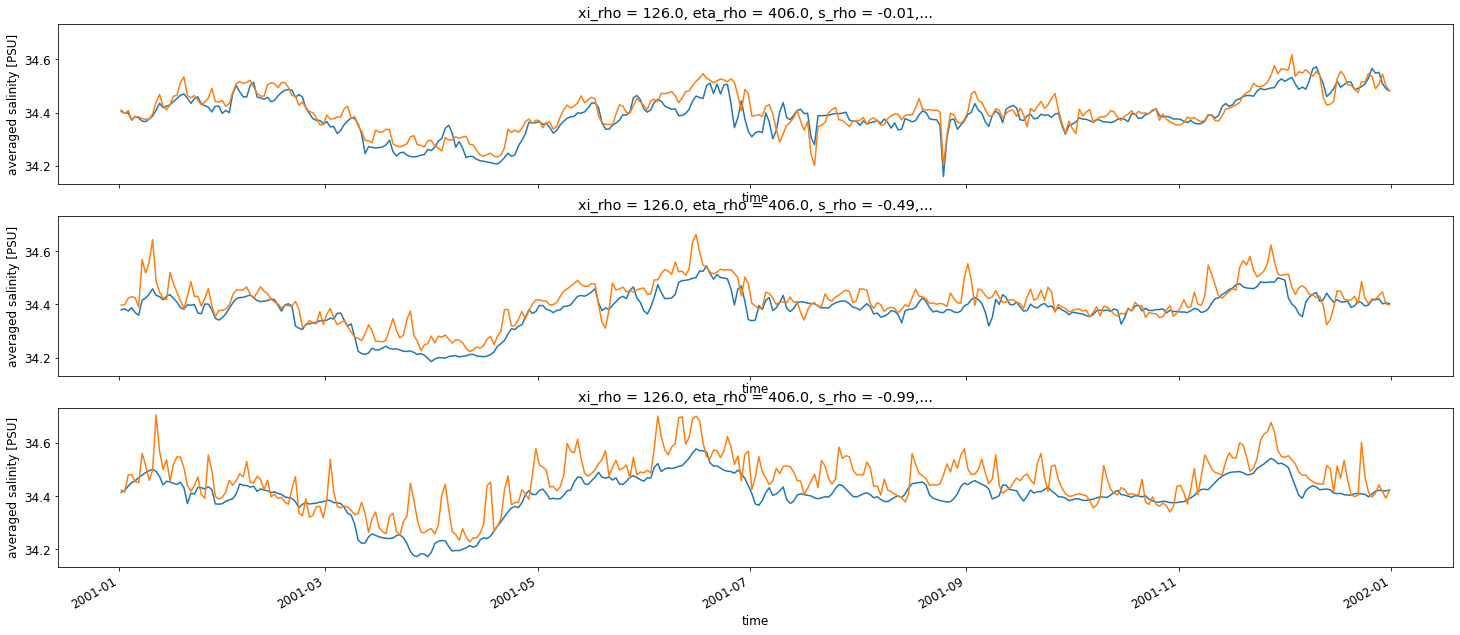

In [44]:
ts_control = control.salt.sel(eta_rho=406, xi_rho=126)
ts_rivers  = rivers.salt.sel(eta_rho=406, xi_rho=126)
fig, ax = plt.subplots(3,1, sharex=True, sharey=True, figsize=(25,10))
ts_control.isel(s_rho=-1).plot(ax=ax[0])
ts_rivers.isel(s_rho=-1).plot(ax=ax[0])

ts_control.isel(s_rho=25).plot(ax=ax[1])
ts_rivers.isel(s_rho=25).plot(ax=ax[1])

ts_control.isel(s_rho=0).plot(ax=ax[2])
ts_rivers.isel(s_rho=0).plot(ax=ax[2])


(array([18., 12., 29., 62., 74., 76., 54., 25.,  7.,  8.]),
 array([34.228325, 34.276085, 34.323845, 34.3716  , 34.41936 , 34.46712 ,
        34.51488 , 34.56264 , 34.610397, 34.658157, 34.705917],
       dtype=float32),
 <BarContainer object of 10 artists>)

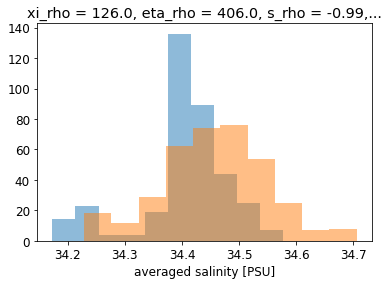

In [45]:
ts_control.isel(s_rho=0).plot.hist(alpha=0.5)
ts_rivers.isel(s_rho=0).plot.hist(alpha=0.5)

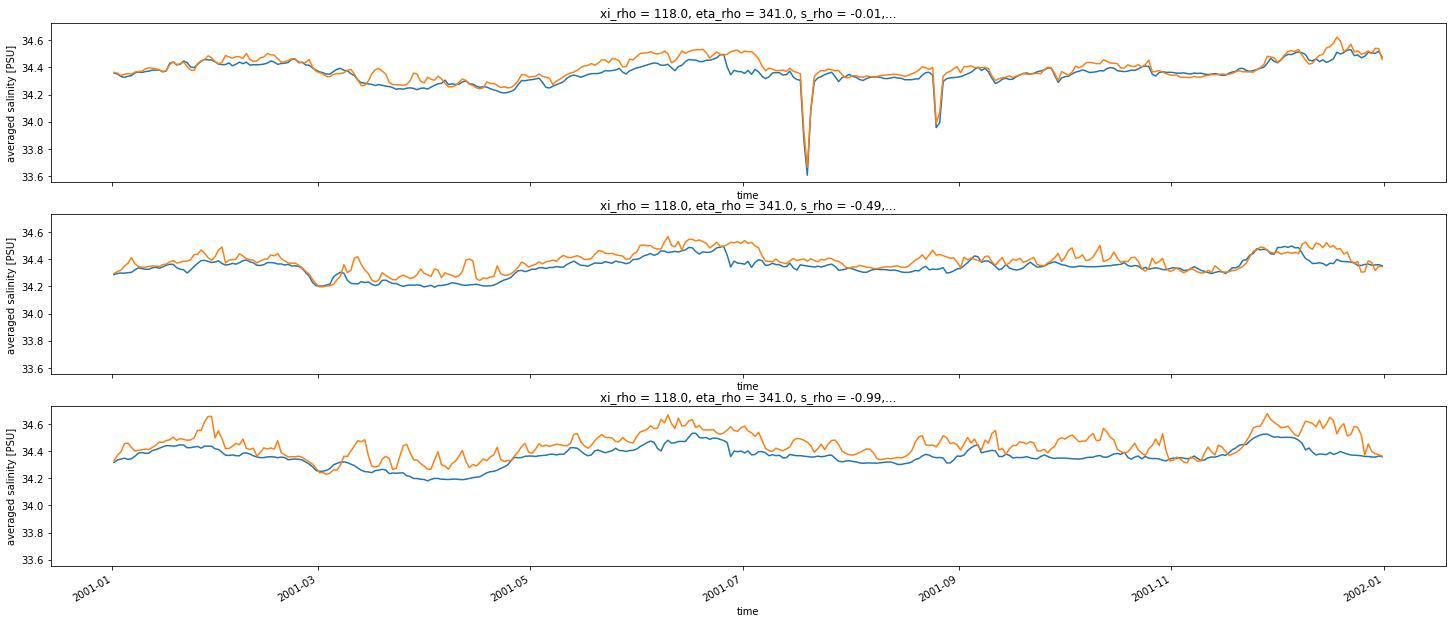

In [6]:
ts_control = control.salt.sel(eta_rho=341, xi_rho=118)
ts_rivers  = rivers.salt.sel(eta_rho=341, xi_rho=118)
fig, ax = plt.subplots(3,1, sharex=True, sharey=True, figsize=(25,10))
ts_control.isel(s_rho=-1).plot(ax=ax[0])
ts_rivers.isel(s_rho=-1).plot(ax=ax[0])

ts_control.isel(s_rho=25).plot(ax=ax[1])
ts_rivers.isel(s_rho=25).plot(ax=ax[1])

ts_control.isel(s_rho=0).plot(ax=ax[2])
ts_rivers.isel(s_rho=0).plot(ax=ax[2])

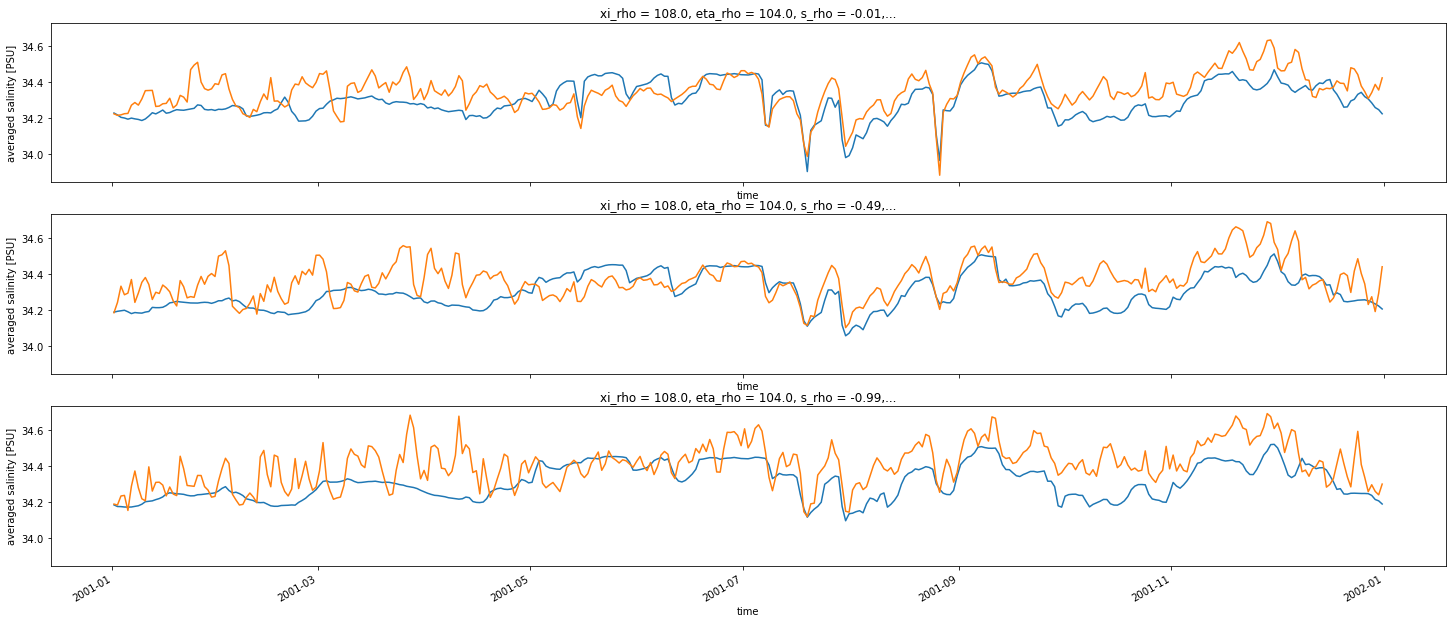

In [7]:
ts_control = control.salt.sel(eta_rho=104, xi_rho=108)
ts_rivers  = rivers.salt.sel(eta_rho=104, xi_rho=108)
fig, ax = plt.subplots(3,1, sharex=True, sharey=True, figsize=(25,10))
ts_control.isel(s_rho=-1).plot(ax=ax[0])
ts_rivers.isel(s_rho=-1).plot(ax=ax[0])

ts_control.isel(s_rho=25).plot(ax=ax[1])
ts_rivers.isel(s_rho=25).plot(ax=ax[1])

ts_control.isel(s_rho=0).plot(ax=ax[2])
ts_rivers.isel(s_rho=0).plot(ax=ax[2])

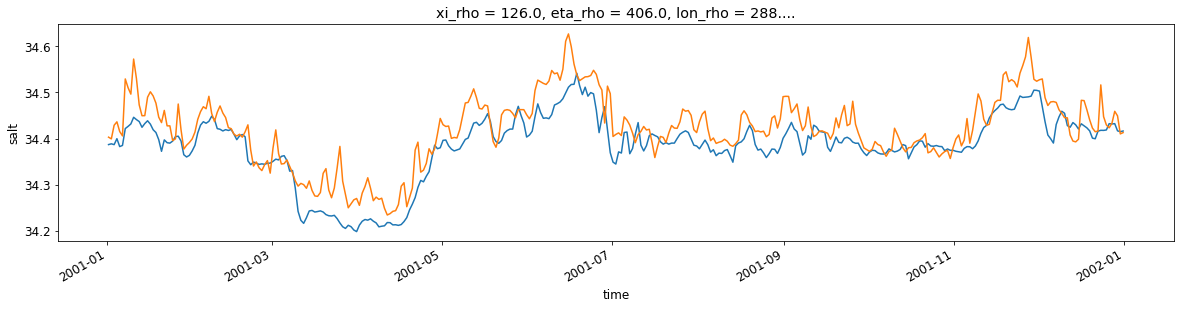

In [43]:
plt.figure(figsize=(20,4))
ts_control.mean('s_rho').plot()
ts_rivers.mean('s_rho').plot()


(array([ 5., 18., 42., 43., 66., 75., 55., 26., 26.,  9.]),
 array([34.119156, 34.1764  , 34.23364 , 34.290882, 34.34812 , 34.405365,
        34.46261 , 34.519848, 34.57709 , 34.63433 , 34.691574],
       dtype=float32),
 <BarContainer object of 10 artists>)

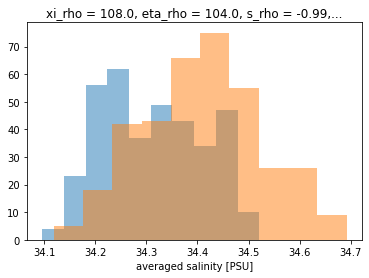

In [8]:
ts_control.isel(s_rho=0).plot.hist(alpha=0.5)
ts_rivers.isel(s_rho=0).plot.hist(alpha=0.5)

In [27]:
bias = (rivers.salt-control.salt).load()

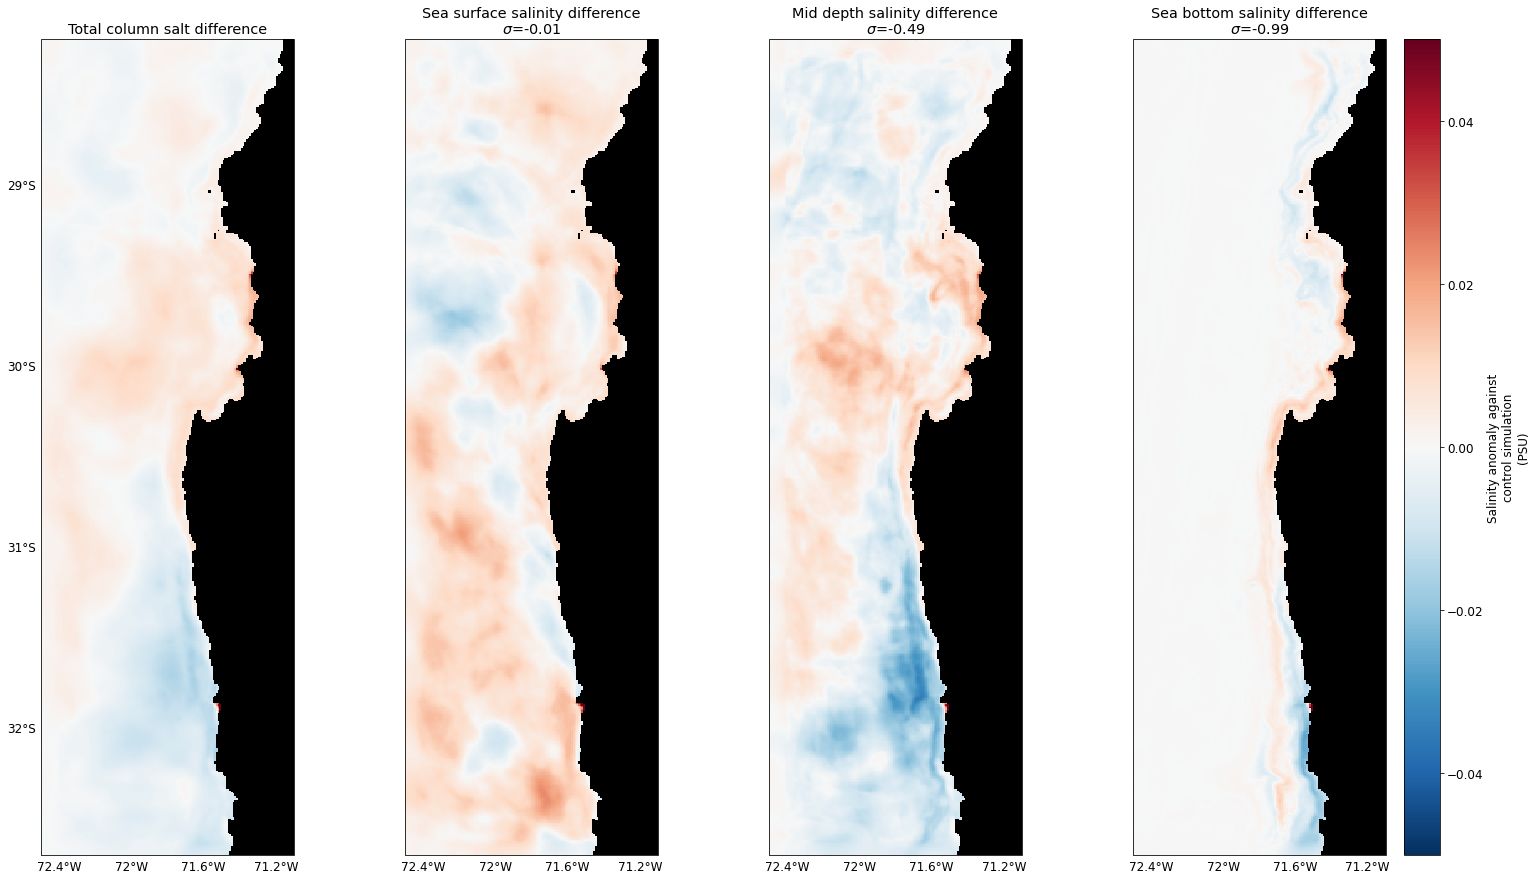

In [30]:
plt.rc('font', size=12)
plt.rc('hatch', color='k')

titles = ['Total column salt difference','Sea surface salinity difference\n$\sigma$=-0.01', 'Mid depth salinity difference\n$\sigma$=-0.49', 'Sea bottom salinity difference\n$\sigma$=-0.99']
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(25,15),
                       subplot_kw={'projection':ccrs.PlateCarree()})
for i,axis in enumerate(ax.ravel()):
    axis.set_title(titles[i])
    axis.pcolormesh(gridd1.lon_rho, gridd1.lat_rho, gridd1.mask_rho.where(gridd1.mask_rho==0), cmap='bone',zorder=1)
    axis.set_extent([-72.5,-71.1,-32.7,-28.19])
    gl = axis.gridlines(draw_labels=True, linewidth=0)
    gl.top_labels=False
    gl.right_labels=False
    if i>0:
        gl.left_labels=False
        
vmin,vmax=-0.05,0.05
hatchtype='//'
cmap='RdBu_r'
ttime = slice('2001','2002')
# -------------------------------- PLOT BIASES ------------------------------- #

m = ((bias).mean('s_rho')).sel(time=ttime).mean('time').plot(
        ax=ax[0], add_labels=False, add_colorbar=False,
        x='lon_rho', y='lat_rho', transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax, zorder=0, cmap=cmap)

bias.isel(s_rho=-1).sel(time=ttime).mean('time').plot(
    ax=ax[1], add_labels=False, add_colorbar=False,
    x='lon_rho', y='lat_rho', transform=ccrs.PlateCarree(),
    vmin=vmin, vmax=vmax, zorder=0, cmap=cmap)


(bias.isel(s_rho=25)).sel(time=ttime).mean('time').plot(
    ax=ax[2], add_labels=False, add_colorbar=False,
    x='lon_rho', y='lat_rho', transform=ccrs.PlateCarree(),
    vmin=vmin, vmax=vmax, zorder=0, cmap=cmap)


(bias.isel(s_rho=0)).sel(time=ttime).mean('time').plot(
    ax=ax[3], add_labels=False, add_colorbar=False,
    x='lon_rho', y='lat_rho', transform=ccrs.PlateCarree(),
    vmin=vmin, vmax=vmax, zorder=0, cmap=cmap)


# --------------------------- PLOT SIGNIFICANT RMSE -------------------------- #

#Find places where RMSE(rivers,control)>=1.25*std(control)
# important_2dcum   = (((saltrivers_2Dcum-saltcontrol_2Dcum))**2).sel(time=ttime).mean('time')**0.5     >= 1.0*saltcontrol_2Dcum.sel(time=ttime).std('time')
# important_surface = ((sss_rivers-sss_control)**2).sel(time=ttime).mean('time')**0.5                   >= 1.0*sss_control.sel(time=ttime).std('time')
# important_sigma25 = (((saltrivers_sigma25-saltcontrol_sigma25)**2).sel(time=ttime).mean('time'))**0.5 >= 1.0*saltcontrol_sigma25.sel(time=ttime).std('time')
# important_sigma50 = (((saltrivers_sigma50-saltcontrol_sigma50)**2).sel(time=ttime).mean('time'))**0.5 >= 1.0*saltcontrol_sigma50.sel(time=ttime).std('time')

# important_2dcum.where(gridd0.mask_rho==1).plot.contourf(
#     add_labels=False, add_colorbar=False,levels=[-1,0,1], ax=ax[0],
#     x='lon_rho', y='lat_rho', hatches=['',hatchtype], cmap='none',
#     transform=ccrs.PlateCarree())

# important_surface.where(gridd0.mask_rho==1).plot.contourf(
#     add_labels=False, add_colorbar=False,levels=[-1,0,1], ax=ax[1],
#     x='lon_rho', y='lat_rho', hatches=['',hatchtype], cmap='none',
#     transform=ccrs.PlateCarree())

# important_sigma25.where(gridd0.mask_rho==1).plot.contourf(
#     add_labels=False, add_colorbar=False,levels=[-1,0,1], ax=ax[2],
#     x='lon_rho', y='lat_rho', hatches=['',hatchtype], cmap='none',
#     transform=ccrs.PlateCarree())

# important_sigma50.where(gridd0.mask_rho==1).plot.contourf(
#     add_labels=False, add_colorbar=False,levels=[-1,0,1], ax=ax[3],
#     x='lon_rho', y='lat_rho', hatches=['',hatchtype], cmap='none',
#     transform=ccrs.PlateCarree())

# --------------------------------- COLORBAR --------------------------------- #

bbox = ax[-1].get_position()
cax  = fig.add_axes([bbox.xmax+0.01, bbox.ymin, 0.02, bbox.ymax-bbox.ymin])
fig.colorbar(m, cax=cax, label='Salinity anomaly against\ncontrol simulation\n(PSU)')

In [72]:
x=rivers.salt.isel(s_rho=-0).quantile(0.99, 'time')-control.salt.isel(s_rho=-1).quantile(0.99, 'time')

In [122]:
x = bias.isel(s_rho=0).mean('time')
y = bias.isel(s_rho=25).mean('time')
z = bias.isel(s_rho=-1).mean('time')
w = bias.mean('s_rho').mean('time')


xx = bias.isel(s_rho=0).std('time')
yy = bias.isel(s_rho=25).std('time')
zz = bias.isel(s_rho=-1).std('time')
ww = bias.mean('s_rho').std('time')


In [123]:
valx = xr.concat([x.where(gridd1.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(566)], 'eta_rho')
valy = xr.concat([y.where(gridd1.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(566)], 'eta_rho')
valz = xr.concat([z.where(gridd1.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(566)], 'eta_rho')
valw = xr.concat([w.where(gridd1.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(566)], 'eta_rho')

valxx = xr.concat([xx.where(gridd1.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(566)], 'eta_rho')
valyy = xr.concat([yy.where(gridd1.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(566)], 'eta_rho')
valzz = xr.concat([zz.where(gridd1.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(566)], 'eta_rho')
valww = xr.concat([ww.where(gridd1.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(566)], 'eta_rho')



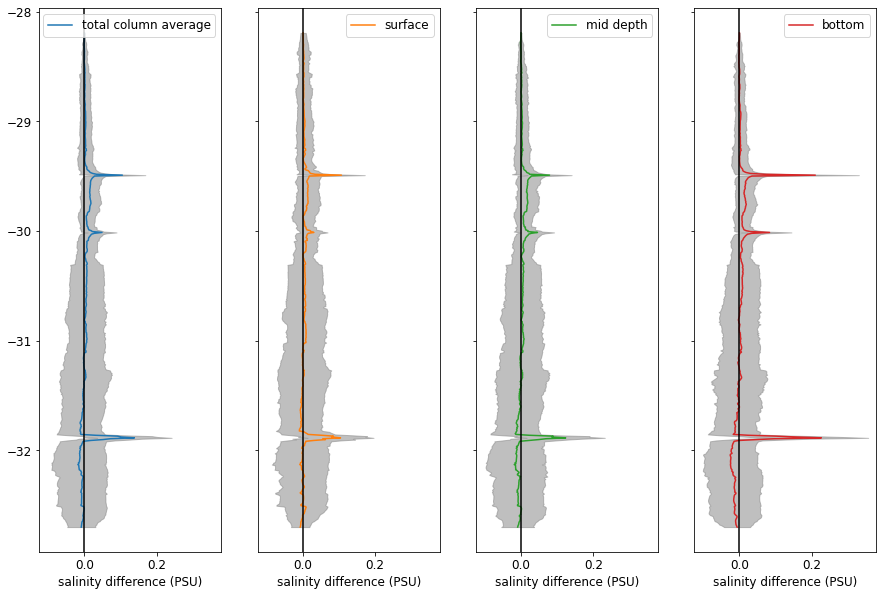

In [144]:
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(15,10))

ax[0].plot(valw,valw.lat_rho, label='total column average')
ax[1].plot(valz,valw.lat_rho, label='surface', color='tab:orange')
ax[2].plot(valy,valw.lat_rho, label='mid depth', color='tab:green')
ax[3].plot(valx,valw.lat_rho, label='bottom', color='tab:red')

ax[0].fill_betweenx(valw.lat_rho, valw+valww,valw-valww, color='grey', alpha=0.5)
ax[1].fill_betweenx(valw.lat_rho, valz+valzz,valz-valzz, color='grey', alpha=0.5)
ax[2].fill_betweenx(valw.lat_rho, valy+valyy,valy-valyy, color='grey', alpha=0.5)
ax[3].fill_betweenx(valw.lat_rho, valx+valxx,valx-valxx, color='grey', alpha=0.5)

for axis in ax.ravel():
    axis.axvline(0, color='k', ls="-")
    axis.legend()
    axis.set_xlabel('salinity difference (PSU)')

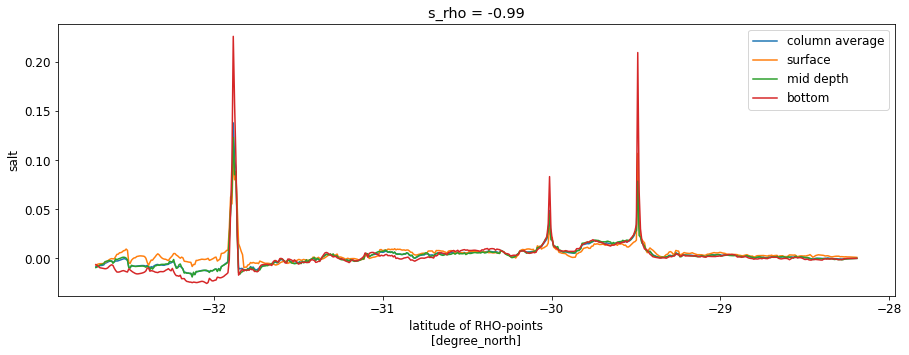

In [118]:

xr.concat(valw,'eta_rho').plot(x='lat_rho', figsize=(15,5), label='column average')
xr.concat(valz,'eta_rho').plot(x='lat_rho', label='surface')
xr.concat(valy,'eta_rho').plot(x='lat_rho', label='mid depth')
xr.concat(valx,'eta_rho').plot(x='lat_rho', label='bottom')

plt.legend()